In [1]:
import pandas as pd
import numpy as np

# Import and clean the data.
### Drop "bad" MET-test data and add "good" MET-test data.

In [2]:
# Import the FRIEND dataset
#df_full = pd.read_excel('FRIEND_dataset_with_City_4_23_21.xlsx')
col_interest = ["ID", "Facility", "ageattest", "testdate", "Gender", "Country", 
               "weight", "height", "BMI", "ANYCVD", "COPD", "BetaMed",
                "Mode", "vo2_ml_kg_min", "vo2_l_min", "max_hr", "max_rer",
                "max_load_watts"]

df_full = pd.read_excel('FRIEND_dataset_with_City_6_14_21.xlsx', usecols=col_interest)

# Import the "cleaned" MET-test dataset that was used in previous pubs.
# Kaminsky et al. 2017, MCP
df_met = pd.read_excel('CLEANED MET-test FRIEND Cycling data_4_25_2021.xlsx', usecols=col_interest)

In [3]:
# Filter out the "unclean" MET-test from FRIEND dataset.

filt = (df_full['Facility'] == 'MET-test')
df_full.drop(index=df_full[filt].index, inplace=True)

#df_full['Facility'].value_counts()

In [4]:
# Fix date formatting between the 2 datasets.
df_met['testdate'] = df_met['testdate'].astype('datetime64[ns]')
df_met['testdate'] = pd.to_datetime(df_met['testdate'], format='%y%m%d')

df_full['testdate'] = df_full['testdate'].astype('datetime64[ns]')
df_full['testdate'] = pd.to_datetime(df_full['testdate'], format='%y%m%d')

#df_full['testdate']

In [5]:
# Add in the "clean" MET-test data to the FRIEND dataset.
df = df_full.append(df_met)

#df['Facility'].value_counts()

In [6]:
#pd.set_option('display.max_columns', 85)
#df

### Dropping tests/ Cleaning up dataset.

In [38]:
# Drop those not coded as M/F.
# The other df.drop method drops more F for some reason...

df.query('Gender == "Female" | Gender == "Male"', inplace=True)

In [39]:
# Keep only USA data.
#df['Country'].unique()

df.query('Country == "USA"', inplace=True)

In [40]:
# Include only treadmill or cycling tests.
#df['Mode'].unique()

df.query('Mode == "TM" | Mode == "CY"', inplace=True)

In [41]:
# Drops those with 0 for height, weight, age, or VO2.

df['weight'] = df['weight'].astype(float)
df['height'] = df['height'].astype(float)
df['ageattest'] = df['ageattest'].astype(float)
df['vo2_ml_kg_min'] = df['vo2_ml_kg_min'].astype(float)

df.dropna(how="any", subset=['height','weight','ageattest','vo2_ml_kg_min'], inplace=True)

df.query('height > 0 & weight > 0', inplace=True)
df.query('ageattest > 0 & vo2_ml_kg_min > 0', inplace=True)

In [42]:
# If max HR is >250 or < 30, make the value missing.
#df['max_hr'] = pd.to_numeric(df['max_hr'], errors='coerce')

#df['max_hr'].values[df['max_hr'].values > 250] = None
#df['max_hr'].values[df['max_hr'].values < 30] = None

In [43]:
# If max HR is >250 or < 30, make the value missing.
df['max_hr'] = pd.to_numeric(df['max_hr'], errors='coerce')

df.loc[df.max_hr > 250, "max_hr"] = None
df.loc[df.max_hr < 30, "max_hr"] = None

In [44]:
# If max cycling workload is 0, make the value missing.
df['max_load_watts'] = pd.to_numeric(df['max_load_watts'], errors='coerce')
df['max_load_watts'].values[df['max_load_watts'].values < 1] = None

In [45]:
# Drops those with CVD (but keeps those with CVD missing).
# The cleaned MET-test data has ANYCVD missing but they're supposed to be healthy.

# the .ge is 'greater than or equal' (AND KEEPS nan).
filt = (df['ANYCVD'].ge(1))
df=df[~filt]

In [46]:
# Drops those with COPD (but keeps those with COPD missing (a lot of sites)).

df['COPD'] = df['COPD'].astype(float)
filt = (df['COPD'].ge(1))
df=df[~filt]

In [47]:
# Drops those taking beta meds (but keeps missing beta meds).

df['BetaMed'] = df['BetaMed'].astype(float)
filt = (df['BetaMed']).ge(1)
df=df[~filt]

In [48]:
# Keeps only 20-89 year olds.

df.query('ageattest >= 20 & ageattest <90', inplace=True)

In [49]:
# Keeps only RER≥1.0.

df.query('max_rer >= 1.0', inplace=True)

In [50]:
#df['Country'].value_counts()

#df['Gender'].value_counts()

# Look at Facility to get count of mode by Gender group.
#df.groupby(['Gender', 'Mode']).agg('count')

#df['Mode'].value_counts()

#df['Facility'].value_counts()

#max(df['testdate'])

In [51]:
# Create age groups.

def age_grouping(df):
    if(df['ageattest'] >= 20 and df['ageattest'] <30):
        return '20s'
    elif(df['ageattest'] >= 30 and df['ageattest'] <40):
        return '30s'
    elif(df['ageattest'] >= 40 and df['ageattest'] <50):
        return '40s'
    elif(df['ageattest'] >= 50 and df['ageattest'] <60):
        return '50s'
    elif(df['ageattest'] >= 60 and df['ageattest'] <70):
        return '60s'
    elif(df['ageattest'] >= 70 and df['ageattest'] <80):
        return '70s'
    elif(df['ageattest'] >= 80 and df['ageattest'] <90):
        return '80s'
    
df['ageGroup'] = df.apply(age_grouping, axis=1)

In [52]:
# Fix some outliers in terms of height and weight.

df["height"] = np.where(df["height"] < 50, np.nan, df["height"])
df["height"] = np.where(df["height"] > 90, np.nan, df["height"])

df["weight"] = np.where(df["weight"] < 30, np.nan, df["weight"])

In [53]:
# Create SI units for height and weight.

df['weightSI'] = (df['weight'] / 2.205)
df['heightSI'] = (df['height'] * 2.54)

In [54]:
# The weights (in "lbs") for Pennington and MGH are messed up for some reason. 
# So, using the BMI to back-calculate the weights (their BMI values seem normal).

df["weightSI"] = np.where(df["Facility"] == "Pennington", (df.BMI * (df.heightSI/100)**2), df["weightSI"])
df["weightSI"] = np.where(df["Facility"] == "MGH", (df.BMI * (df.heightSI/100)**2), df["weightSI"])

In [55]:
# Calculate a new BMI so there are no outliers. 

df["bmi_correct"] = df["weightSI"] / (df["heightSI"]/100)**2

In [56]:
# Drop some outliers in terms of RER.

df["max_rer"] = np.where(df["max_rer"] > 3.0, np.nan, df["max_rer"])

In [59]:
df.sort_values("weight", ascending=True).head(30)

,ID,Facility,testdate,ageattest,Gender,Country,height,weight,BMI,BetaMed,...,Mode,max_load_watts,max_rer,vo2_l_min,vo2_ml_kg_min,max_hr,ageGroup,weightSI,heightSI,bmi_correct
98144,11,GSU,2019-02-18,21.0,Male,USA,69.7,26.8,3.90,0.0,...,CY,210.0,1.35,0.54,44.40,194.0,20s,12.154195,177.038,3.877870
119387,259809,MAYO,2012-07-16,29.9,Female,USA,60.8,78.5,14.90,0.0,...,TM,NaN,1.24,1.12,31.50,173.0,20s,35.600907,154.432,14.927479
97175,185,Hartford Hospital,2010-01-06,52.0,Female,USA,60.2,78.8,15.30,0.0,...,TM,NaN,1.16,NaN,31.20,158.0,50s,35.736961,152.908,15.284710
115274,233700,MAYO,2009-10-27,30.9,Female,USA,57.9,79.4,16.70,0.0,...,TM,NaN,1.45,0.63,17.40,176.0,30s,36.009070,147.066,16.648969
462,81,BWH,2009-01-09,61.0,Female,USA,68.0,80.0,12.20,0.0,...,CY,NaN,1.11,NaN,33.20,74.0,60s,36.281179,172.720,12.161752
97176,185,Hartford Hospital,2010-07-16,52.0,Female,USA,60.6,80.1,15.30,0.0,...,TM,NaN,1.15,NaN,28.20,NaN,50s,36.326531,153.924,15.332439
104096,56654,Ball State,2006-03-23,45.0,Female,USA,57.2,80.6,17.30,0.0,...,TM,NaN,1.05,1.29,35.20,179.0,40s,36.553288,145.288,17.316773
115273,224345,MAYO,2008-10-20,29.9,Female,USA,57.5,82.2,17.50,0.0,...,TM,NaN,1.26,0.60,16.20,164.0,20s,37.278912,146.050,17.476727
115275,242879,MAYO,2010-10-20,31.9,Female,USA,58.1,84.5,17.60,0.0,...,TM,NaN,1.52,0.57,14.80,173.0,30s,38.321995,147.574,17.596586
117471,218996,MAYO,2008-03-11,23.4,Female,USA,60.2,86.9,16.90,0.0,...,TM,NaN,1.21,0.81,20.50,157.0,20s,39.410431,152.908,16.855854


In [58]:
# Saving some of this data for Malene at Stanford and her ELITE project.

Malene_col_int = ["ageattest", "ageGroup", "Gender", "vo2_ml_kg_min", "Mode", "max_rer"]

df_malene = df[Malene_col_int]

# Double check to make sure the sample sizes look right with the publication.
# print(df_malene["Mode"].value_counts())
# print("\n")
# print("Cycling:", "\n", df_malene[(df["Mode"] == "CY")].groupby(["ageGroup", "Gender"]).count())
# print("\n")
# print("Treadmill:", "\n", df_malene[(df["Mode"] == "TM")].groupby(["ageGroup", "Gender"]).count())


# writer = pd.ExcelWriter('2021_FRIEND_data_for_Malene.xlsx', engine='xlsxwriter')
# df_malene.to_excel(writer)
# writer.save()

# Creating Summary Tables

#### Mean ± SD of variables of interest.

In [29]:
#df.query('Facility != "CU AESL"', inplace=True)

In [30]:
#df['Facility'].value_counts()

In [31]:
# ALL RER ≥1.0.

var_int = ['sampleSize', 'ageattest', 'heightSI', 'weightSI', 'bmi_correct',\
           'sampleSize','vo2_ml_kg_min', 'vo2_l_min',\
           'max_load_watts', 'max_hr', 'max_rer']
# Including a summary of ALL ages too.
age_int = ['20s','30s','40s','50s','60s','70s', '80s', 'All']
sex_int = ['Male','Female']
mode_int = ['TM','CY']

# Create dataframe to write the results to.
dfSum = pd.DataFrame(index=var_int)
dfSum.index.name = 'Variables'            

for modes in mode_int:
    for sexes in sex_int:
        for ages in age_int:
            if ages == 'All':
                df_temp = df[(df['Mode']==modes) & (df['Gender']==sexes)]
            else:                      
                df_temp = df[(df['Mode']==modes) & (df['Gender']==sexes) & \
                         (df['ageGroup']==ages)]
            
            for var in var_int:
                if var == 'sampleSize':
                    new_label = f'{modes}_{sexes}_{ages}'
                    samp_size = int(len(df_temp['vo2_ml_kg_min']))
                    dfSum.loc[var, new_label] = f'n = {samp_size}'
                elif var == 'max_rer' or var == 'vo2_l_min':
                    temp_mean = f'{round(df_temp[var].mean(),2):.2f}'
                    temp_sd = f'{round(df_temp[var].std(),2):.2f}'
                    new_label = f'{modes}_{sexes}_{ages}'
                    dfSum.loc[var, new_label] = f'{temp_mean} ± {temp_sd}'
                elif var == 'max_load_watts':
                    temp_mean = f'{round(df_temp[var].mean(),0):.0f}'
                    temp_sd = f'{round(df_temp[var].std(),0):.0f}'
                    new_label = f'{modes}_{sexes}_{ages}'
                    dfSum.loc[var, new_label] = f'{temp_mean} ± {temp_sd}'    
                else:
                    temp_mean = f'{round(df_temp[var].mean(),1):.1f}'
                    temp_sd = f'{round(df_temp[var].std(),1):.1f}'
                    new_label = f'{modes}_{sexes}_{ages}'
                    dfSum.loc[var, new_label] = f'{temp_mean} ± {temp_sd}'

#dfSum

In [32]:
# ONLY RER ≥1.10.

dfHighRER = df.query('max_rer >= 1.1')


# Create dataframe to write the results to.
dfSumHighRER = pd.DataFrame(index=var_int)
dfSumHighRER.index.name = 'Variables'            

for modes in mode_int:
    for sexes in sex_int:
        for ages in age_int:
            if ages == 'All':
                df_temp = dfHighRER[(dfHighRER['Mode']==modes) & \
                                (dfHighRER['Gender']==sexes)]
            else:
                df_temp = dfHighRER[(dfHighRER['Mode']==modes) & \
                                (dfHighRER['Gender']==sexes) & \
                         (dfHighRER['ageGroup']==ages)]
            
            for var in var_int:
                if var == 'sampleSize':
                    new_label = f'{modes}_{sexes}_{ages}'
                    samp_size = int(len(df_temp['vo2_ml_kg_min']))
                    dfSumHighRER.loc[var, new_label] = f'n = {samp_size}'
                elif var == 'max_rer' or var == 'vo2_l_min':
                    temp_mean = f'{round(df_temp[var].mean(),2):.2f}'
                    temp_sd = f'{round(df_temp[var].std(),2):.2f}'
                    new_label = f'{modes}_{sexes}_{ages}'
                    dfSumHighRER.loc[var, new_label] = f'{temp_mean} ± {temp_sd}'   
                elif var == 'max_load_watts':
                    temp_mean = f'{round(df_temp[var].mean(),0):.0f}'
                    temp_sd = f'{round(df_temp[var].std(),0):.0f}'
                    new_label = f'{modes}_{sexes}_{ages}'
                    dfSumHighRER.loc[var, new_label] = f'{temp_mean} ± {temp_sd}' 
                else:
                    temp_mean = f'{round(df_temp[var].mean(),1):.1f}'
                    temp_sd = f'{round(df_temp[var].std(),1):.1f}'
                    new_label = f'{modes}_{sexes}_{ages}'
                    dfSumHighRER.loc[var, new_label] = f'{temp_mean} ± {temp_sd}'
                    
#dfSumHighRER

#### VO2max Percentiles.

In [33]:
# ALL RER ≥1.0.

# Percentiles of interest and grouping variables.
perc_int = list(np.arange(10,100, 10))
perc_int.reverse()
age_int = ['20s','30s','40s','50s','60s','70s','80s']
sex_int = ['Male','Female']
mode_int = ['TM','CY']

# Create dataframe to write the results to.
dfPerc = pd.DataFrame(index = perc_int)
dfPerc.index.name = 'Percentiles'            

for modes in mode_int:
    for sexes in sex_int:
        for ages in age_int:
            new_col_name = modes +'_' + sexes + '_' + ages 
            dfPerc[new_col_name] = None
            dfTemp = df[(df['Mode']==modes) & (df['Gender']==sexes) \
                            & (df['ageGroup']==ages)]
            
            for percs in perc_int:
                dfPerc.loc[percs, new_col_name] \
                = f"{round(np.percentile(dfTemp['vo2_ml_kg_min'], percs),1):.1f}"
# dfPerc

In [34]:
# ONLY RER ≥1.10.

# For more detailed percentiles.
perc_int = [0.2]
perc_int.extend(list(np.arange(5,100, 5)))
perc_int.append(99.8)
perc_int.reverse()

# Create dataframe to write the results to.
dfPercHighRER = pd.DataFrame(index = perc_int)
dfPercHighRER.index.name = 'Percentiles'            

for modes in mode_int:
    for sexes in sex_int:
        for ages in age_int:
            new_col_name = modes +'_' + sexes + '_' + ages 
            dfPercHighRER[new_col_name] = None
            dfTemp = dfHighRER[(dfHighRER['Mode']==modes) \
                               & (dfHighRER['Gender']==sexes) \
                               & (dfHighRER['ageGroup']==ages)]
            
            for percs in perc_int:
                dfPercHighRER.loc[percs, new_col_name] \
                = f"{round(np.percentile(dfTemp['vo2_ml_kg_min'], percs),1):.1f}"

# dfPercHighRER

# --Saving Files.--

In [35]:
writer = pd.ExcelWriter('FRIENDupdates_11_24_2021.xlsx', engine='xlsxwriter')
# writer = pd.ExcelWriter('FRIENDupdates_for_percentiles_.xlsx', engine='xlsxwriter')

dfSum.to_excel(writer, sheet_name='AveragesAll')
dfPerc.to_excel(writer, sheet_name='PercentilesAll')
dfSumHighRER.to_excel(writer, sheet_name='AveragesHighRER')
dfPercHighRER.to_excel(writer, sheet_name='PercentilesHighRER')

writer.save()

# --Graphing.--

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

In [1]:
# BOXPLOT WITH SEABORN.

df.sort_values(by='ageGroup', ascending=True, inplace=True)

# TREADMILL 
dfTMmale = df[(df['Mode']=='TM') & (df['Gender']=='Male')]
dfTMfemale = df[(df['Mode']=='TM') & (df['Gender']=='Female')]

# set the figure size.
plt.figure(figsize=(5,8))

# Do the top figure.
plt.subplot(2,1,1)
boxPlotMales = sns.boxplot(y='vo2_ml_kg_min', x='ageGroup',
                     data=dfTMmale,
                     color='lightgray')
plt.xlabel('Age Group (years)')
# mathregular keeps the font the same as the rest (and not italisized).
plt.ylabel('$\mathregular{VO_{2peak} (ml\cdot{}kg^{-1}\cdot{}min^{-1})}$')
# Make the lines all black.
plt.setp(boxPlotMales.artists, edgecolor = 'black')
plt.setp(boxPlotMales.lines, color = 'black')
# Set axis range
#plt.ylim(10,100)


# Do the bottom figure.
plt.subplot(2,1,2)
boxPlotFemales = sns.boxplot(y='vo2_ml_kg_min', x='ageGroup',
                     data=dfTMfemale,
                     color='gray')
plt.xlabel('Age Group (years)')
plt.ylabel('$\mathregular{VO_{2peak} (ml\cdot{}kg^{-1}\cdot{}min^{-1})}$')
plt.setp(boxPlotFemales.artists, edgecolor = 'black')
plt.setp(boxPlotFemales.lines, color = 'black')


plt.show()

# white facecolor makes the background white. 
#plt.savefig('anotherTest.tif', facecolor='white', dpi=150)


NameError: name 'df' is not defined

In [30]:
# Create new variable that uses men/women (since that's what Lenny prefers).
def Sex(df):
    if(df['Gender'] == "Male"):
        return "Men"
    else:
        return "Women"
    
df['Sex'] = df.apply(Sex, axis=1)

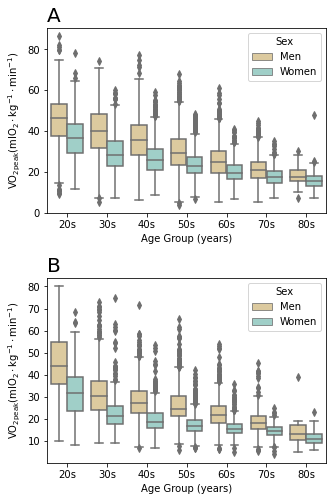

In [31]:
# These are the ones I like.

df.sort_values(by=['ageGroup','Sex'], ascending=[True,True], inplace=True)


# set the figure size.
plt.figure(figsize=(5,8))


# TREADMILL 
dfTM = df[(df['Mode']=='TM')]

# set the figure size.
#plt.figure(figsize=(5,8))

# palette 'Greys' or 'Greys_r'
# other palettes I like: vlag, Blues_r, BrBG, GnBu_r

# Do the top figure.
plt.subplot(2,1,1)
boxPlot = sns.boxplot(y='vo2_ml_kg_min', x='ageGroup', hue='Sex',
                     data=dfTM,
                     palette='BrBG')
plt.title("A", loc="left", size=20)
plt.xlabel('Age Group (years)')
# mathregular keeps the font the same as the rest (and not italisized).
plt.ylabel('$\mathregular{VO_{2peak} (mlO_{2} \cdot{}kg^{-1}\cdot{}min^{-1})}$')
# Make the lines all black.
#plt.setp(boxPlotMales.artists, edgecolor = 'black')
#plt.setp(boxPlotMales.lines, color = 'black')
# Set axis range
#plt.ylim(10,100)


#plt.show()

# white facecolor makes the background white. 
#plt.savefig('treadmillBoxPlot.tif', facecolor='white', dpi=150)



# Do the bottom figure.
plt.subplot(2,1,2)
# CYCLING. 
dfCY = df[(df['Mode']=='CY')]

# set the figure size.
#plt.figure(figsize=(5,8))

# palette 'Greys' or 'Greys_r'
# other palettes I like: vlag, Blues_r, BrBG, GnBu_r
boxPlot = sns.boxplot(y='vo2_ml_kg_min', x='ageGroup', hue='Sex',
                     data=dfCY,
                     palette='BrBG')
plt.title("B", loc="left", size=20)
plt.xlabel('Age Group (years)')
# mathregular keeps the font the same as the rest (and not italisized).
plt.ylabel('$\mathregular{VO_{2peak} (mlO_{2} \cdot{}kg^{-1}\cdot{}min^{-1})}$')
# Make the lines all black.
#plt.setp(boxPlotMales.artists, edgecolor = 'black')
#plt.setp(boxPlotMales.lines, color = 'black')
# Set axis range
#plt.ylim(10,100)

plt.subplots_adjust(hspace=.35)


#plt.show()

# white facecolor makes the background white. 
# MCP wants 300 dpi.
plt.savefig('treadmillAndCyclingBoxPlot.tif', facecolor='white', dpi=300)

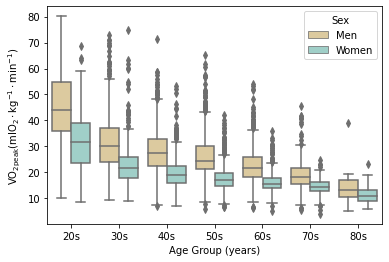

In [33]:
df.sort_values(by=['ageGroup','Sex'], ascending=[True,True], inplace=True)

# CYCLING. 
dfCY = df[(df['Mode']=='CY')]

# set the figure size.
#plt.figure(figsize=(5,8))

# palette 'Greys' or 'Greys_r'
# other palettes I like: vlag, Blues_r, BrBG, GnBu_r
boxPlot = sns.boxplot(y='vo2_ml_kg_min', x='ageGroup', hue='Sex',
                     data=dfCY,
                     palette='BrBG')
plt.xlabel('Age Group (years)')
# mathregular keeps the font the same as the rest (and not italisized).
plt.ylabel('$\mathregular{VO_{2peak} (mlO_{2} \cdot{}kg^{-1}\cdot{}min^{-1})}$')
# Make the lines all black.
#plt.setp(boxPlotMales.artists, edgecolor = 'black')
#plt.setp(boxPlotMales.lines, color = 'black')
# Set axis range
#plt.ylim(10,100)


#plt.show()

# white facecolor makes the background white. 
plt.savefig('cyclingBoxPlot.tif', facecolor='white', dpi=150)

In [ ]:
# BOXPLOT WITH PANDAS.

# TM 

dfTM = df[(df['Mode']=='TM')]
gender_grpTM = dfTM.groupby('Gender')

boxplot = gender_grpTM.boxplot(column = 'vo2_ml_kg_min', by='ageGroup',
                               layout=(2,1), 
                               grid=False,
                               patch_artist=True)
#plt.suptitle('')

In [ ]:
# Old Shtuff.

In [ ]:
# ALL RER ≥1.0.

# State what we want to group by and the variables of interest.
modeGenderAge_grp = df.groupby(['Mode', 'Gender', 'ageGroup'])

var_int = ['vo2_ml_kg_min', 'vo2_l_min', 'max_rer', 'ageattest', 'heightSI', 'weightSI', 'BMI']

# Create a data frame that's a summary of the grouped variables of interest.
dfSumTemp = modeGenderAge_grp[var_int].describe()

# Then modify to create a printable mean±sd and keep sample sizes.
for x in range(len(var_int)):
    if var_int[x] == 'max_rer' or var_int[x] == 'vo2_l_min':
        dfSumTemp[var_int[x]+'_Summary'] = dfSumTemp[var_int[x]]['mean'].round(2).astype(str) + ' ± ' + dfSumTemp[var_int[x]]['std'].round(2).astype(str)
        dfSumTemp[var_int[x]+'_n'] = dfSumTemp[var_int[x]]['count'].astype(int) 
    else:
        dfSumTemp[var_int[x]+'_Summary'] = dfSumTemp[var_int[x]]['mean'].round(1).astype(str) + ' ± ' + dfSumTemp[var_int[x]]['std'].round(1).astype(str)
        dfSumTemp[var_int[x]+'_n'] = dfSumTemp[var_int[x]]['count'].astype(int) 
    
# And then drop unwanted columns to have a cleaned up version of things.
dfSumTemp.columns = dfSumTemp.columns.droplevel(1)

dfSumN = dfSumTemp[dfSumTemp.columns[dfSumTemp.columns.str.contains(pat = '_n')][0]]
dfSumAvg = dfSumTemp[dfSumTemp.columns[dfSumTemp.columns.str.contains(pat = '_Summary')]]

dfSum = pd.concat([dfSumN, dfSumAvg], axis=1)
dfSum = dfSum.rename(columns = {dfSum.columns[0]: 'N'})
dfSum.columns = dfSum.columns.str.replace('_Summary', '')
dfSum = dfSum.transpose()
#dfSum

In [ ]:
# ONLY RER ≥1.10.

dfHighRER = df.query('max_rer >= 1.1')

modeGenderAge_grpHighRER = dfHighRER.groupby(['Mode', 'Gender', 'ageGroup'])


# Create a data frame that's a summary of the grouped variables of interest.
dfSumTempHighRER = modeGenderAge_grpHighRER[var_int].describe()

# Then modify to create a printable mean±sd and keep sample sizes.
for x in range(len(var_int)):
    if var_int[x] == 'max_rer' or var_int[x] == 'vo2_l_min':
        dfSumTempHighRER[var_int[x]+'_Summary'] = dfSumTempHighRER[var_int[x]]['mean'].round(2).astype(str) + ' ± ' + dfSumTempHighRER[var_int[x]]['std'].round(2).astype(str)
        dfSumTempHighRER[var_int[x]+'_n'] = dfSumTempHighRER[var_int[x]]['count'].astype(int) 
    else:
        dfSumTempHighRER[var_int[x]+'_Summary'] = dfSumTempHighRER[var_int[x]]['mean'].round(1).astype(str) + ' ± ' + dfSumTempHighRER[var_int[x]]['std'].round(1).astype(str)
        dfSumTempHighRER[var_int[x]+'_n'] = dfSumTempHighRER[var_int[x]]['count'].astype(int) 
    
# And then drop unwanted columns to have a cleaned up version of things.
dfSumTempHighRER.columns = dfSumTempHighRER.columns.droplevel(1)

dfSumNhighRER = dfSumTempHighRER[dfSumTempHighRER.columns[dfSumTempHighRER.columns.str.contains(pat = '_n')][0]]
dfSumAvgHighRER = dfSumTempHighRER[dfSumTempHighRER.columns[dfSumTempHighRER.columns.str.contains(pat = '_Summary')]]

dfSumHighRER = pd.concat([dfSumNhighRER, dfSumAvgHighRER], axis=1)
dfSumHighRER = dfSumHighRER.rename(columns = {dfSumHighRER.columns[0]: 'N'})
dfSumHighRER.columns = dfSumHighRER.columns.str.replace('_Summary', '')
dfSumHighRER = dfSumHighRER.transpose()

#dfSumHighRER

In [ ]:
# ALL RER ≥1.0.

# Percentiles of interest and grouping variables.
perc_int = list(np.arange(10,100, 10).round(2))
age_int = ['20s','30s','40s','50s','60s','70s','80s']
sex_int = ['Male','Female']
mode_int = ['TM','CY']

# Create dataframe to write the results to.
dfPerc = pd.DataFrame(index = perc_int)
dfPerc.index.name = 'Percentiles'            

for modes in mode_int:
    for sexes in sex_int:
        for ages in age_int:
            dfTemp = df[(df['Mode']==modes) & (df['Gender']==sexes) \
                        & (df['ageGroup']==ages)]
            dfPerc[modes + '_' + sexes + '_' + ages] \
            = dfTemp['vo2_ml_kg_min'].quantile(perc_int).round(1)
            
#dfPerc  

In [ ]:
# ONLY RER ≥1.10.

# Create dataframe to write the results to.
dfPercHighRER = pd.DataFrame(index = perc_int)
dfPercHighRER.index.name = 'Percentiles'            

for x in range(len(mode_int)):
    for y in range(len(sex_int)):
        for z in range(len(age_int)):
            dfTemp = dfHighRER[(dfHighRER['Mode']==mode_int[x]) \
                               & (dfHighRER['Gender']==sex_int[y]) \
                               & (dfHighRER['ageGroup']==age_int[z])]
            dfPercHighRER[mode_int[x]+'_'+sex_int[y]+'_'+age_int[z]] \
            = dfTemp['vo2_ml_kg_min'].quantile(perc_int).round(1)

#dfPercHighRER